# La Liga Experiments

Here, we examine the answering abilities of LLMs on historical data of team standings in La Liga. 

## Imports

In [30]:
import numpy as numpy
import pandas as pd 
import wikipedia
import together
from tqdm import tqdm
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import warnings

#set tqdm pandas
tqdm.pandas()

#supress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load Data on La Liga Winners

Here we load data on La Liga winners from Wikipedia. We have data on the winning team, second place team, third place team, and Top Scorer.

In [43]:
#load data from wikipedia on La Liga Champions
laliga_champions_page = wikipedia.page("List of Spanish football champions")

#load_champions table
laliga_champions_df = pd.read_html(laliga_champions_page.html())[2]

#clean up the data
laliga_champions_df = laliga_champions_df.iloc[:, 0:10]
laliga_champions_df.columns = ['Season', 'Champion', 'ChampionPoints', 'RunnerUp', 'RunnerUpPoints', 'ThirdPlace', 'ThirdPlacePoints', 'TopScorer', 'TopScorerClub', 'Goals']
laliga_champions_df = laliga_champions_df.apply(lambda x: x.apply(lambda x2: x2.split('(')[0].strip()))
laliga_champions_df = laliga_champions_df.astype({column: 'str' for column in laliga_champions_df.columns})

#Madrid FC is now Real Madrid, Atletico Aviacion is now Atletico Madrid. Below code will replace the old names with the new names
laliga_champions_df = laliga_champions_df.replace("Madrid FC[a]", "Real Madrid").replace('Atlético Aviación[b]', 'Atlético Madrid')

#three seasons were missed due to the Spanish Civil War. Below code will remove those seasons
laliga_champions_df = laliga_champions_df[laliga_champions_df['Champion'] != 'League suspended due to Spanish Civil War']

#save data
laliga_champions_df.to_csv('data/raw_laliga_data.csv', index=False)

C:\Users\jasko\AppData\Local\Temp\ipykernel_15968\1989636479.py:5: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  laliga_champions_df = pd.read_html(laliga_champions_page.html())[2]


## Questions And Prompts

Here, we define the questions (prompts) that we will use for our evaluation.

In [75]:
questions = [
    "What team was the champion of the {season} La Liga season?",
    "What team was the runner-up (second-place) of the {season} La Liga season?",
    "What team was the third-place of the {season} La Liga season?"
]

#overall prompt

prompt = """
Disregard all previous instructions. Answer the following question about the La Liga football league by providing a club name only on the first line.

{question}

"""

## Evaluate Model

Below, we run the model over our dataset and questions.

In [79]:
MODEL = "meta-llama/Llama-3-8B-chat-hf"

MAX_TOKENS = 100
TEMPERATURE = 0

#load together ai api key
with open('api_key.txt', 'r') as file:
    api_key = file.read()

#init together ai client
together_ai = together.Together(api_key=api_key)

#load data
laliga_champions_df = pd.read_csv('data/raw_laliga_data.csv')

#function to evaluate a datapoint
def evaluate_datapoint(datapoint):
    
    season = datapoint['Season']

    season_eval_results = {}
    
    for question in questions:

        formatted_prompt = prompt.format(question=question.format(season=season))

        response = together_ai.chat.completions.create(
            model=MODEL,
            max_tokens=MAX_TOKENS,
            temperature=TEMPERATURE,
            messages=[{"role": "user", "content": formatted_prompt}]
        )

        season_eval_results[question] = response.choices[0].message.content

    return pd.Series(season_eval_results)

laliga_llm_results = laliga_champions_df.progress_apply(evaluate_datapoint, axis=1)

laliga_llm_results.to_csv('data/model_outputs/llama3-8b/laliga_llm_results.csv', index=False)



100%|██████████| 93/93 [07:49<00:00,  5.05s/it]


Now we process the model's outputs, and calculate our evaluation metrics.

In [100]:
#join the results with the original data
laliga_champions_with_model_results_df = pd.concat([laliga_champions_df, laliga_llm_results], axis=1)

#get set of all teams mentioned
all_teams = set(laliga_champions_with_model_results_df[['Champion', 'RunnerUp', 'ThirdPlace']].stack().unique())

#0 = correct
#1 = hallucinated
#2 = no answer

def eval_model_response(datapoint):

    season = datapoint['Season']
    
    actual_champion = datapoint['Champion'].strip().lower()
    actual_runner_up = datapoint['RunnerUp'].strip().lower()
    actual_third_place = datapoint['ThirdPlace'].strip().lower()

    predicted_champion = datapoint['What team was the champion of the {season} La Liga season?'].strip().lower()
    predicted_runner_up = datapoint['What team was the runner-up (second-place) of the {season} La Liga season?'].strip().lower()
    predicted_third_place = datapoint['What team was the third-place of the {season} La Liga season?'].strip().lower()

    champion_result = 0 if predicted_champion == actual_champion else (1 if predicted_champion in all_teams else 2)
    runner_up_result = 0 if predicted_runner_up == actual_runner_up else (1 if predicted_runner_up in all_teams else 2)
    third_place_result = 0 if predicted_third_place == actual_third_place else (1 if predicted_third_place in all_teams else 2)

    return pd.Series({
        'Season': season,
        'ChampionResult': champion_result,
        'RunnerUpResult': runner_up_result,
        'ThirdPlaceResult': third_place_result
    })

results = laliga_champions_with_model_results_df.apply(eval_model_response, axis=1)

results['correct_percentage'] = results.apply(lambda x: (x == 0).sum(), axis=1)
results['hallucinated_percentage'] = results.apply(lambda x: (x == 1).sum(), axis=1)
results['no_answer_percentage'] = results.apply(lambda x: (x == 2).sum(), axis=1)

display(results)

,Season,ChampionResult,RunnerUpResult,ThirdPlaceResult,correct_percentage,hallucinated_percentage,no_answer_percentage
0,1929,2,2,0,1,1,2
1,1929–30,0,2,2,1,1,2
2,1930–31,0,2,2,1,1,2
3,1931–32,2,0,2,1,1,2
4,1932–33,2,0,2,1,1,2
...,...,...,...,...,...,...,...
88,2019–20,2,2,2,0,0,3
89,2020–21,0,2,2,1,1,2
90,2021–22,0,0,2,2,0,2
91,2022–23,2,2,2,0,0,3


Now, we plot our results across time.

C:\Users\jasko\AppData\Local\Temp\ipykernel_15968\1622072211.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  results['year'].replace({1900: 2000}, inplace=True)


,Season,ChampionResult,RunnerUpResult,ThirdPlaceResult,correct_percentage,hallucinated_percentage,no_answer_percentage,year
0,1929,2,2,0,1,1,2,1929
1,1929–30,0,2,2,1,1,2,1930
2,1930–31,0,2,2,1,1,2,1931
3,1931–32,2,0,2,1,1,2,1932
4,1932–33,2,0,2,1,1,2,1933
5,1933–34,0,2,2,1,1,2,1934
6,1934–35,2,2,2,0,0,3,1935
7,1935–36,0,2,2,1,1,2,1936
8,1939–40,2,2,0,1,1,2,1940
9,1940–41,2,0,2,1,1,2,1941


Text(0, 0.5, 'Number Hallucinated')

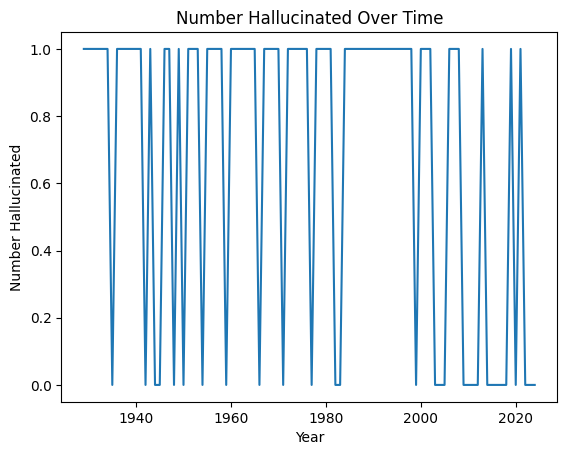

In [106]:
results['year'] = results['Season'].apply(lambda x: x[:2] + x[-2:]).astype(int)

results['year'].replace({1900: 2000}, inplace=True)

x = 0

display(results.iloc[x:(x+10)])

plt.plot(results['year'], results['hallucinated_percentage'], label='Correct')

plt.title('Number Hallucinated Over Time')
plt.xlabel('Year')

plt.ylabel('Number Hallucinated')

## More expansive data

We expand our results from above by gathering more expansive data. Here, we will query the model to identify what position each team finished in. We gather and format this data below.

In [82]:
la_liga_seasons = pd.read_csv('data/raw_laliga_data.csv')['Season'].iloc[49:]

league_tables = pd.DataFrame(columns=['Pos', 'Teamvte', 'Pld', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts', 'Qualification/Relegation'])

for season in tqdm(la_liga_seasons):
    
    season_wiki_page_html = BeautifulSoup(wikipedia.page(f'{season} La Liga').html())

    league_table_div = season_wiki_page_html.find(['h2', 'h3', 'h4', 'h5', 'h6'], {'id': 'League_table'}).find_next('table')

    league_table_df = pd.read_html(str(league_table_div))[0]

    #set index to current season
    league_table_df.index = pd.Series([season] * len(league_table_df))

    league_tables = pd.concat([league_tables, league_table_df])

  0%|          | 0/44 [00:00<?, ?it/s]

100%|██████████| 44/44 [01:44<00:00,  2.38s/it]


Let us clean up the data that we gathered.

In [84]:
league_tables_combined = league_tables.drop(['Qualification/Relegation', 'Qualification or relegation', 'Qualification'], axis=1)

league_tables_combined['Team'] = league_tables_combined['Team'].fillna(league_tables_combined['Teamvte'])
league_tables_combined.drop('Teamvte', axis=1, inplace=True)
league_tables_combined['Team'] = league_tables_combined['Team'].apply(lambda x: x.split('(')[0].strip())

display(league_tables_combined)

,Pos,Pld,W,D,L,GF,GA,GD,Pts,Team
1980–81,1,34,20,5,9,66,37,+29,45,Real Sociedad
1980–81,2,34,19,7,8,52,29,+23,45,Real Madrid
1980–81,3,34,17,8,9,59,41,+18,42,Atlético Madrid
1980–81,4,34,16,10,8,46,39,+7,42,Valencia
1980–81,5,34,18,5,11,66,41,+25,41,Barcelona
...,...,...,...,...,...,...,...,...,...,...
2023–24,16,38,10,10,18,33,47,−14,40[c],Las Palmas
2023–24,17,38,8,14,16,29,48,−19,38,Rayo Vallecano
2023–24,18,38,6,15,17,26,55,−29,33,Cádiz
2023–24,19,38,3,12,23,43,75,−32,21[d],Almería


Here we set up our question and prompt.

In [85]:
question = "In the {season} La Liga season, in what position did {team} finish?"

#overall prompt

prompt = """
Disregard all previous instructions. Answer the following question about the La Liga football league results by providing a singular integer value only on the first line.

{question}

"""

## Evaluation

Now we do evaluation.

In [86]:
MODEL = "meta-llama/Llama-3-70b-chat-hf"

MAX_TOKENS = 100
TEMPERATURE = 0

#load together ai api key
with open('api_key.txt', 'r') as file:
    api_key = file.read()

#init together ai client
together_ai = together.Together(api_key=api_key)

def evaluate_datapoint(datapoint):
    
    season = datapoint.name
    team = datapoint['Team']

    formatted_prompt = prompt.format(question=question.format(season=season, team=team))

    response = together_ai.chat.completions.create(
        model=MODEL,
        max_tokens=MAX_TOKENS,
        temperature=TEMPERATURE,
        messages=[{"role": "user", "content": formatted_prompt}]
    )

    return response.choices[0].message.content

league_tables_combined['PredictedPos'] = league_tables_combined.progress_apply(evaluate_datapoint, axis=1)

100%|██████████| 870/870 [19:46<00:00,  1.36s/it]


Evaluate the quality of the predictions.

In [87]:
league_tables_combined["PosDiff"] = (league_tables_combined["Pos"] - league_tables_combined["PredictedPos"].astype(int)).abs()
league_tables_combined["accurate_prediction"] = league_tables_combined["PosDiff"] == 0

In [92]:
display(league_tables_combined)

league_tables_combined.to_csv('data/model_outputs/llama3-70b/league_tables_pred_results.csv', index=True)

,Pos,Pld,W,D,L,GF,GA,GD,Pts,Team,PredictedPos,PosDiff,accurate_prediction
1980–81,1,34,20,5,9,66,37,+29,45,Real Sociedad,1,0,True
1980–81,2,34,19,7,8,52,29,+23,45,Real Madrid,2,0,True
1980–81,3,34,17,8,9,59,41,+18,42,Atlético Madrid,3,0,True
1980–81,4,34,16,10,8,46,39,+7,42,Valencia,4,0,True
1980–81,5,34,18,5,11,66,41,+25,41,Barcelona,5,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023–24,16,38,10,10,18,33,47,−14,40[c],Las Palmas,20,4,False
2023–24,17,38,8,14,16,29,48,−19,38,Rayo Vallecano,12,5,False
2023–24,18,38,6,15,17,26,55,−29,33,Cádiz,18,0,True
2023–24,19,38,3,12,23,43,75,−32,21[d],Almería,12,7,False


1980–81      1.722222
1981–82      1.333333
1982–83      2.222222
1983–84      2.944444
1984–85      1.611111
1985–86      1.833333
1986–87      2.333333
1987–88           3.4
1988–89          1.45
1989–90           1.1
1990–91          2.35
1991–92          3.15
1992–93           2.4
1993–94          1.45
1994–95          1.85
1995–96      1.772727
1996–97      1.318182
1997–98          1.55
1998–99          2.15
1999–2000        0.95
2000–01           1.7
2001–02          1.75
2002–03           0.6
2003–04           1.1
2004–05           0.9
2005–06           0.4
2006–07           0.5
2007–08           0.1
2008–09           0.7
2009–10           0.5
2010–11           0.4
2011–12           0.2
2012–13           0.5
2013–14           0.8
2014–15           0.4
2015–16           0.4
2016–17          0.05
2017–18          0.25
2018–19          0.45
2019–20           0.1
2020–21           0.0
2021–22           0.3
2022–23          0.65
2023–24           2.9
Name: PosDiff, dtype: object

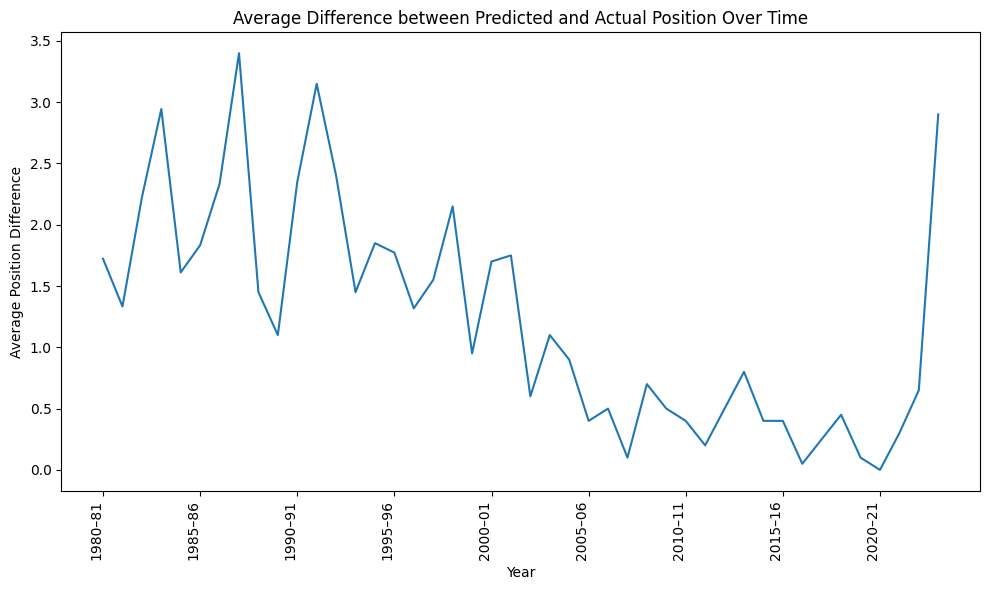

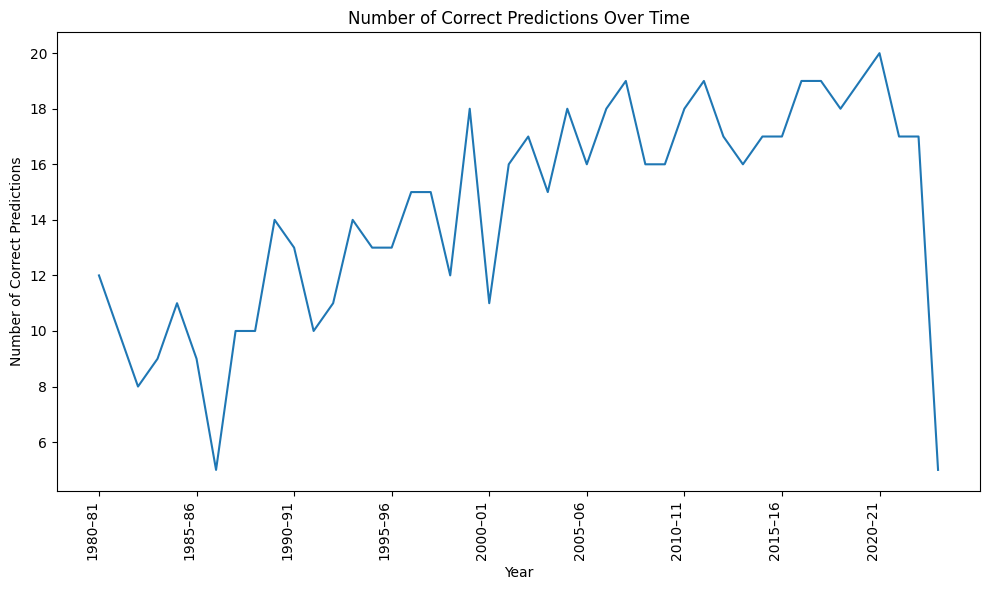

In [90]:
avg_diff_by_season = league_tables_combined['PosDiff'].groupby(league_tables_combined.index).mean()
num_correct_by_season = league_tables_combined['accurate_prediction'].groupby(league_tables_combined.index).sum()

display(avg_diff_by_season)

plt.figure(figsize=(10, 6))
plt.plot(avg_diff_by_season.index, avg_diff_by_season.values)
plt.title('Average Difference between Predicted and Actual Position Over Time')
plt.xlabel('Year')
plt.xticks(rotation=90, ha='right', ticks=range(0, len(avg_diff_by_season), 5))
plt.ylabel('Average Position Difference')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(avg_diff_by_season.index, num_correct_by_season.values)
plt.title('Number of Correct Predictions Over Time')
plt.xlabel('Year')
plt.xticks(rotation=90, ha='right', ticks=range(0, len(avg_diff_by_season), 5))
plt.ylabel('Number of Correct Predictions')

plt.tight_layout()
plt.show()